# **US Company Bankruptcy Prediction Dataset**





***Problem Motivation:***

The motivation behind the U.S. Company Bankruptcy Prediction Dataset revolves around the critical need to predict the financial distress or bankruptcy of companies. This is an important aspect for investors, creditors, policymakers, and other stakeholders in the business world for several reasons:
1. Risk Management and Investment Decisions
2. Early Warning for Companies
3. Financial Market Stability
4. Policy Making and Economic Research
5. Credit Scoring and Financial Services
6. Legal and Compliance Implications
7. Supply Chain Management
8. Employee and Stakeholder Interests

In summary, the U.S. Company Bankruptcy Prediction Dataset serves as a crucial tool for various stakeholders to anticipate financial distress in companies, enabling proactive measures in investment, policy making, risk management, and strategic planning.

***Analysis Methodology:***

In the context of the U.S. Company Bankruptcy Prediction Dataset, the analysis methodology include the following stages:
*   Data Collection and Preparation:
    1. Data Collection: A novel dataset for bankruptcy prediction related to American public companies listed on the New York Stock Exchange and NASDAQ is provided. The dataset comprises accounting data from 8,262 distinct companies recorded during the period spanning from 1999 to 2018.
    2. Data Cleaning: The data cleaning process for the US Company Bankruptcy Prediction Dataset involved three steps:
        1. Null Value Removal: Missing values were identified and eliminated to maintain data accuracy and integrity.
        2. Qualitative to Quantitative Transformation: Categorical data was converted into numerical format, making it compatible with statistical and machine learning models.
        3. Column Header Revision: Column names (X1 to X18) were standardized for clarity and consistency, enhancing the dataset's usability and readability.
     

*   Exploratory Data Analysis (EDA): Conducted the analyses like visualization,
identifying patterns and correlations. The following analyses were conducted:
    1. Yearly Revenue and Yealy Liability Against Year.
    2. Yearly Net Sales, Yearly Gross Profit Against Year.
    3. Company Status Distribution.
    4. Total Revenue Trend Over the Year for Top 5 Companies.
    5. Depreciation Over the Year.
    6. Relation Between Total Income and Market Value for Top 10 Companies.


*   Models Used: KNN, Xgboost, Random Forest

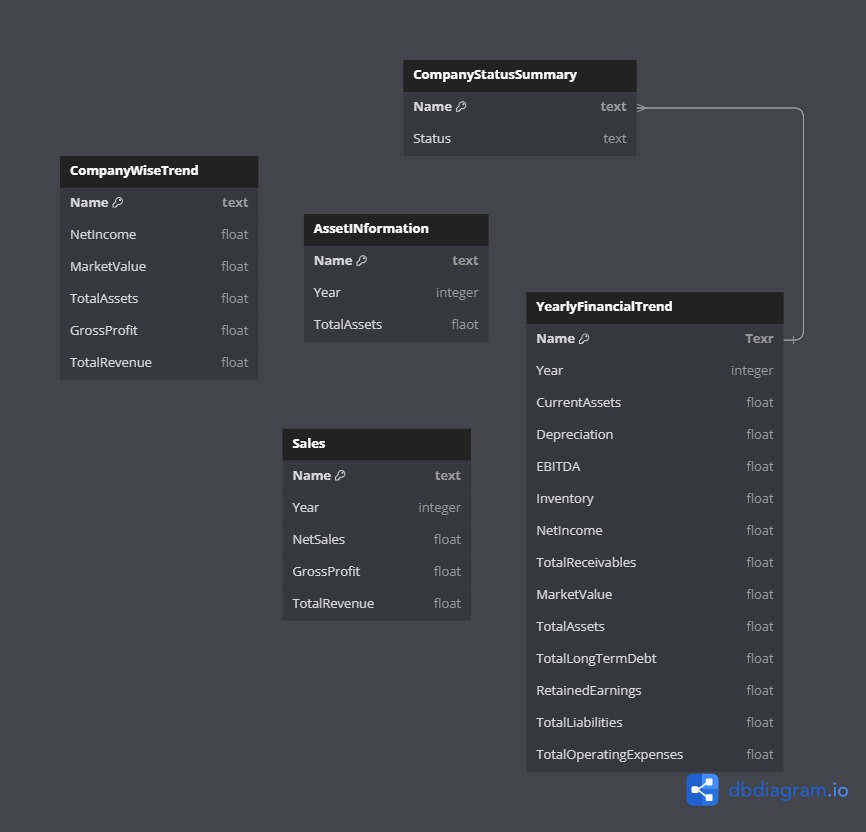









      



    




In [ ]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
%%sql
sqlite:///bankrupcy.db

In [ ]:
import sqlite3
from sqlite3 import Error
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parsing Component and Database Component

In [ ]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [ ]:
def create_table(conn, create_table_sql, drop_table_name=None):

    if drop_table_name: # You can optionally pass drop_table_name to drop the table.
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [ ]:
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

In [ ]:
normalized_database_filename="bankrupcy.db"
data_filename="american_bankruptcy.csv"

In [ ]:
# Data Cleaning
df = pd.read_csv(data_filename)
df.loc[df['status_label'] == 'alive', 'status_label'] = 1
df.loc[df['status_label'] == 'failed', 'status_label'] = 0
# Changing column header
df.rename(columns={df.columns[3]: 'Current Assets',df.columns[4]: 'Cost Of Goods Sold',df.columns[5]: 'Depreciation and amortization',df.columns[6]: 'EBITDA',df.columns[7]: 'Inventory',df.columns[8]: 'Net Income',df.columns[9]: 'Total Receivables',df.columns[10]: 'Market value',df.columns[11]: 'Net sales',df.columns[12]: 'Total assets',df.columns[13]: 'Total Long-term debt',df.columns[14]: 'EBIT',df.columns[15]: 'Gross Profit',df.columns[16]: 'Total Current Liabilities',df.columns[17]: 'Retained Earnings',df.columns[18]: 'Total Revenue',df.columns[19]: 'Total Liabilities',df.columns[20]: 'Total Operating Expenses'},inplace=True)

# Save the modified DataFrame back to the same CSV file
df.to_csv('/content/american_bankruptcy.csv', index=False)

In [ ]:
import re

def custom_sort_key(company_name):
    match = re.search(r'\d+', company_name[0])
    numeric_part = int(match.group()) if match else float('inf')
    return numeric_part

def table1_CompanyStatusSummary(data_filename, normalized_database_filename):
    CompanyStatusSummary = set()
    with open(data_filename, 'r') as file:
      for line in file:
        line = line.split(",")
        company_name = line[0]
        status_label = line[1]
        unique_key = (company_name, status_label)
        CompanyStatusSummary.add(unique_key)

    CompanyStatusSummary = sorted(CompanyStatusSummary, key=custom_sort_key)
    conn_norm = create_connection(normalized_database_filename)
    create_table_1 = """
    CREATE TABLE [CompanyStatusSummary] (
        [Name] TEXT NOT NULL,
        [Status] TEXT NOT NULL,
        PRIMARY KEY (Name)
    );
    """


    create_table(conn_norm, create_table_1, drop_table_name='CompanyStatusSummary')

    sql_statement = "INSERT INTO CompanyStatusSummary(Name, Status) VALUES(?, ?)"

    cur = conn_norm.cursor()
    cur.executemany(sql_statement, CompanyStatusSummary)

    conn_norm.commit()
    conn_norm.close()

table1_CompanyStatusSummary(data_filename, normalized_database_filename)

In [ ]:
def table2_YearlyFinancialTrend(data_filename, normalized_database_filename):
    data_tuples = []
    company_list =[]
    with open(data_filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            company_name = row[0]
            year_and_x1_to_x18 = tuple(row[2:19])
            data_tuples.append(year_and_x1_to_x18)
            company_list.append(company_name)
    combined_list = [(company_list[i],) + data_tuples[i] for i in range(len(company_list))]

    conn_norm = create_connection('bankrupcy.db')
    create_table_region = """CREATE TABLE [YearlyFinancialTrend] (
        [Name] TEXT NOT NULL,
        [Year] INTEGER NOT NULL ,
        [CurrentAssets] FLOAT NOT NULL,
        [CostOfGoodsSold] FLOAT NOT NULL,
        [Depreciation] FLOAT NOT NULL,
        [EBITDA] FLOAT NOT NULL,
        [Inventory] FLOAT NOT NULL,
        [NetIncome] FLOAT NOT NULL,
        [TotalReceivables] FLOAT NOT NULL,
        [MarketValue] FLOAT NOT NULL,
        [NetSales] FLOAT NOT NULL,
        [TotalAssets] FLOAT NOT NULL,
        [TotalLongTermDebt] FLOAT NOT NULL,
        [GrossProfit] FLOAT NOT NULL,
        [RetainedEarnings] FLOAT NOT NULL,
        [TotalRevenue] FLOAT NOT NULL,
        [TotalLiabilities] FLOAT NOT NULL,
        [TotalOperatingExpenses] FLOAT NOT NULL);
    """
    create_table(conn_norm, create_table_region,drop_table_name = 'YearlyFinancialTrend')
    sql_statement = "INSERT INTO YearlyFinancialTrend(Name,Year, CurrentAssets, CostOfGoodsSold, Depreciation, EBITDA, Inventory, NetIncome, TotalReceivables, MarketValue, NetSales, TotalAssets, TotalLongTermDebt, GrossProfit, RetainedEarnings, TotalRevenue, TotalLiabilities, TotalOperatingExpenses) VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)"
    cur = conn_norm.cursor()
    cur.executemany(sql_statement, combined_list)
    conn_norm.commit()
    conn_norm.close()


table2_YearlyFinancialTrend(data_filename, normalized_database_filename)

In [ ]:
conn = sqlite3.connect(normalized_database_filename)
cursor = conn.cursor()

step1 = """
CREATE TABLE new_YearlyFinancialTrend AS
SELECT Year, CurrentAssets, Depreciation, EBITDA, Inventory, TotalReceivables, MarketValue, TotalAssets, TotalLongTermDebt, RetainedEarnings, TotalRevenue, TotalLiabilities, TotalOperatingExpenses
FROM YearlyFinancialTrend;
"""
step2 = """
DROP TABLE YearlyFinancialTrend;
"""
step3 ="""
ALTER TABLE new_YearlyFinancialTrend RENAME TO YearlyFinancialTrend;
"""

cursor.execute(step1)
cursor.execute(step2)
cursor.execute(step3)
conn.commit()
conn.close()

In [ ]:
def table3_CompanyWiseFinancialtrend(data_filename, normalized_database_filename):
    company_details = []
    Header=None
    with open(data_filename, 'r') as file:
      for line in file:
        if not Header:
          Header=line
          continue
        line=line.split(",")
        company_details.append((line[0],line[2],line[8],line[10],line[12],line[15],line[18]))

    conn_norm = create_connection('bankrupcy.db')
    create_table_region = """CREATE TABLE [CompanyWiseTrend] (
        [RowID] INTEGER NOT NULL PRIMARY KEY,
        [Name] TEXT NOT NULL,
        [Year] INTEGER NOT NULL,
        [NetIncome] FLOAT NOT NULL,
        [MarketValue] FLOAT NOT NULL,
        [TotalAssets] FLOAT NOT NULL,
        [GrossProfit] FLOAT NOT NULL,
        [TotalRevenue] FLOAT NOT NULL
    );
    """
    create_table(conn_norm, create_table_region,drop_table_name='Company_Financial_Trends')
    sql_statement = "INSERT INTO CompanyWiseTrend(Name,Year,NetIncome,MarketValue,TotalAssets,GrossProfit,TotalRevenue) VALUES(?,?,?,?,?,?,?)"
    cur = conn_norm.cursor()
    cur.executemany(sql_statement,company_details)
    conn_norm.commit()
    conn_norm.close()


table3_CompanyWiseFinancialtrend(data_filename,normalized_database_filename)

table [CompanyWiseTrend] already exists


In [ ]:
def table4_AssetsInformation(data_filename, normalized_database_filename):
    AssetsInformation = []
    with open(data_filename, 'r') as file:
        next(file)
        for line in file:
            line = line.split(",")
            AssetsInformation.append((line[0], line[2], line[12]))

    conn_norm = create_connection(normalized_database_filename)
    create_table_4 = """
    CREATE TABLE [AssetsInformation] (
        [Name] TEXT NOT NULL,
        [Year] INTEGER NOT NULL,
        [TotalAssets] REAL NOT NULL,
        PRIMARY KEY (Name)
    );
    """

    create_table(conn_norm, create_table_4, drop_table_name='AssetsInformation')
    sql_statement = "INSERT OR REPLACE INTO AssetsInformation(Name, Year, TotalAssets) VALUES(?, ?, ?)"
    cur = conn_norm.cursor()
    cur.executemany(sql_statement, AssetsInformation)

    conn_norm.commit()
    conn_norm.close()

table4_AssetsInformation(data_filename, normalized_database_filename)

In [ ]:
def table5_Sales(data_filename, normalized_database_filename):
    Sales = []
    Header=None
    with open(data_filename, 'r') as file:
      for line in file:
        if not Header:
          Header=line
          continue
        line=line.split(",")
        Sales.append((line[0],line[2],line[11],line[15],line[18]))

    conn_norm = create_connection('bankrupcy.db')
    create_table_region = """CREATE TABLE [Sales] (
        [Name] TEXT NOT NULL,
        [Year] INTEGER NOT NULL,
        [NetSales] REAL NOT NULL,
        [GrossProfit] REAL NOT NULL,
        [TotalRevenue] REAL NOT NULL
    );
    """
    create_table(conn_norm, create_table_region,drop_table_name='Sales')
    sql_statement = "INSERT INTO Sales(Name,Year,NetSales,GrossProfit,TotalRevenue) VALUES(?,?,?,?,?)"
    cur = conn_norm.cursor()
    cur.executemany(sql_statement,Sales)
    conn_norm.commit()
    conn_norm.close()


table5_Sales(data_filename, normalized_database_filename)

In [ ]:
conn = sqlite3.connect(normalized_database_filename)
CompanyWiseTrend_query = "SELECT Name,SUM(NetIncome),AVG(MarketValue),AVG(TotalAssets),AVG(GrossProfit) FROM CompanyWiseTrend GROUP BY Name"
CompanyWiseTrend_df = pd.read_sql_query(CompanyWiseTrend_query, conn)
print(CompanyWiseTrend_df.head())
print(len(CompanyWiseTrend_df))

     Name  SUM(NetIncome)  AVG(MarketValue)  AVG(TotalAssets)  \
0     C_1        1377.994        748.541426       1304.731000   
1    C_10       12582.468       5253.193310      11972.011650   
2   C_100         678.066        624.822920        178.432333   
3  C_1000       35299.948      18809.292005       6545.732900   
4  C_1001       41980.400      20111.374065      32477.570000   

   AVG(GrossProfit)  
0        268.311053  
1       1117.853000  
2         38.080267  
3       3433.467300  
4       6536.760000  
8971


# Data Analysis Component

In [ ]:
conn = sqlite3.connect(normalized_database_filename)
# Query to get the list of tables
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print(tables)

                   name
0      CompanyWiseTrend
1  CompanyStatusSummary
2  YearlyFinancialTrend
3     AssetsInformation
4                 Sales


In [ ]:
# Query to retrieve the yearly trends of Total Revenue and Total Liabilities.
query_analysis = """
SELECT Year, SUM(TotalRevenue) YearlyRevenue, SUM(TotalLiabilities) AS YearlyLiabilities
FROM YearlyFinancialTrend
GROUP BY Year;
"""

analysis_data = pd.read_sql_query(query_analysis, conn)

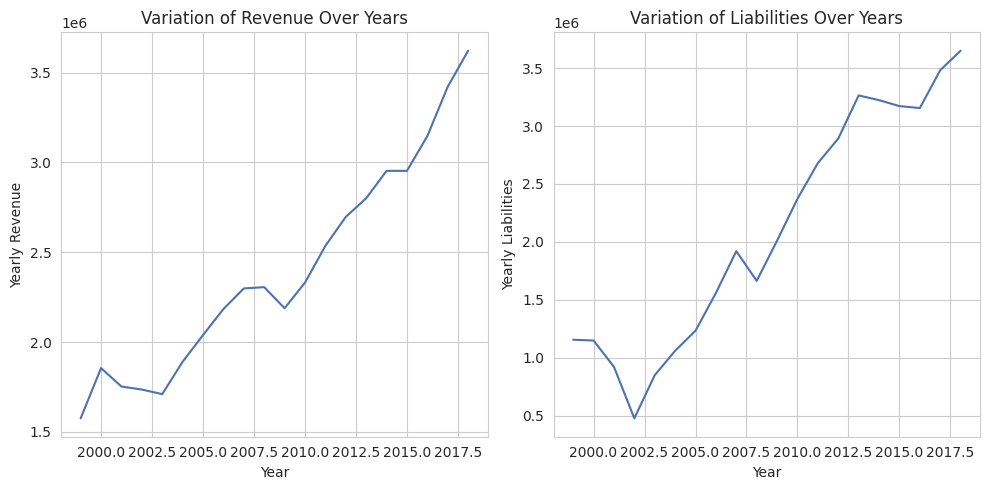

In [ ]:
# Setting the style for the plots
sns.set_style("whitegrid")

# Plotting Total Revenue, Net Income, and Total Liabilities over the years
plt.figure(figsize=(10, 5))

# Total Revenue plot
plt.subplot(1, 2, 1)
sns.lineplot(data=analysis_data, x='Year', y='YearlyRevenue')
plt.title('Variation of Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Yearly Revenue')

# Total Liabilities plot
plt.subplot(1, 2, 2)
sns.lineplot(data=analysis_data, x='Year', y='YearlyLiabilities')
plt.title('Variation of Liabilities Over Years')
plt.xlabel('Year')
plt.ylabel('Yearly Liabilities')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The plots above visualize the trends of Total Revenue and Total Liabilities over the years, as per the data in the YearlyFinancialTrend table.

1. Total Revenue Over Years: This plot shows a general increasing trend in the revenue as year passes. However, around the year 2009, there is a small dip which recovered pretty quickly.

2. Total Liabilities Over Years: The trend in total liabilities is crucial for understanding the debt situation. Increasing liabilities might be a concern, especially if not matched by revenue or income growth. But here the liabilities also increases over the years which some instability around the years 2002 and 2008.

In [ ]:
#The query takes Net Sales, Gross Profit and Total Revenue from the table Sales to plot the graphs over year
query_analysis1 = """
SELECT Year, SUM(NetSales) AS YearlyNetSales, SUM(GrossProfit) AS YearlyGrossProfit, SUM(TotalRevenue) AS YearlyRevenue
FROM Sales
GROUP BY Year;
"""

analysis_data1 = pd.read_sql_query(query_analysis1, conn)
print(analysis_data1.head())

   Year  YearlyNetSales  YearlyGrossProfit  YearlyRevenue
0  1999     5861070.375        1870461.898    5861070.375
1  2000     6622955.570        2033391.860    6622955.570
2  2001     6698553.016        2006465.811    6698553.016
3  2002     6378929.924        1988652.467    6378929.924
4  2003     6871896.247        2171048.696    6871896.247


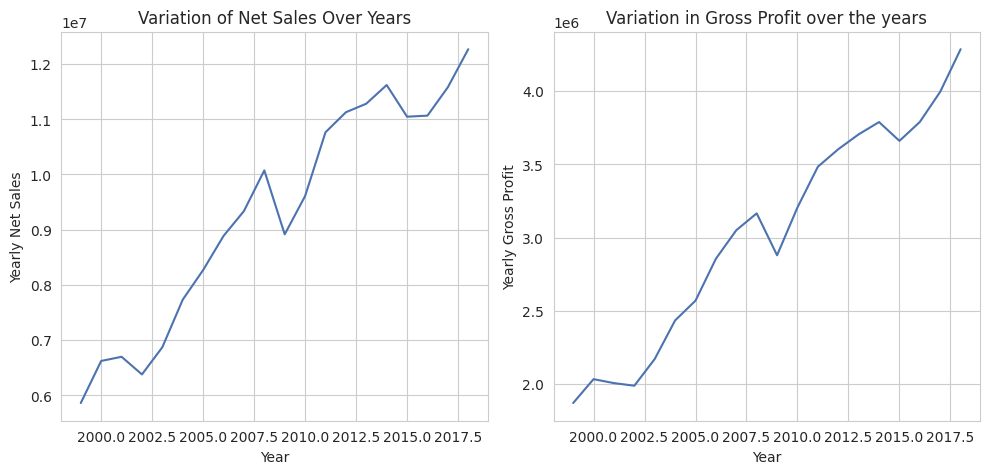

In [ ]:
# Setting the style for the plots
sns.set_style("whitegrid")
sns.set_palette("deep")

# Set the figure size to make the plots smaller
plt.figure(figsize=(10, 5))

# Plot 1: Net Sales
plt.subplot(1, 2, 1)
sns.lineplot(data=analysis_data1, x='Year', y='YearlyNetSales')
plt.title('Variation of Net Sales Over Years')
plt.xlabel('Year')
plt.ylabel('Yearly Net Sales')

# Plot 2: Gross Profit
plt.subplot(1, 2, 2)
sns.lineplot(data=analysis_data1, x='Year', y='YearlyGrossProfit')
plt.title('Variation in Gross Profit over the years')
plt.xlabel('Year')
plt.ylabel('Yearly Gross Profit')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The analysis of Sales table shows that the Net Sales over year and Gross Profit over years follow a general similar trend.
Both have a major dip in the year 2001 and then the values increase from the year 2004. So in the years 2001, 2002, 2003 companies were more prone to bankrupcy.
After that, there are two more dips in around years 2008 and 2014 but they are not that significant.
The Total Revenue was maximum in 2012. The same goes for Gross Profit and Net Sales.
The Net Sales and Total Revenue have are closely similar. This indicates that the Net Sales of the company directly impact on the Total Revenue of the Company.

In [ ]:
#The query counts the number of failed and successful companies from the CompanyStatusSummary table
query_analysis2 = """
SELECT Status, COUNT(*) AS Count
FROM CompanyStatusSummary
GROUP BY Status;
"""

analysis_data2 = pd.read_sql_query(query_analysis2, conn)

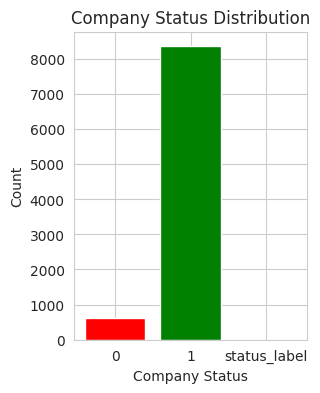

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(3, 4))
# Assuming 'alive' is green and 'failed' is red
plt.bar(analysis_data2['Status'], analysis_data2['Count'], color=['red','green'])
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.title('Company Status Distribution')
plt.show()


The plot shows how many companies survived and how many failed.
From the graph it is evident that the number companies survived is very high
The success rate of a company survival is 94.11%

In [ ]:
#The following query takes Total Revenue over years with company name
query_analysis3 = """
SELECT Name, Year, TotalRevenue
FROM CompanyWiseTrend;
"""
analysis_data3 = pd.read_sql_query(query_analysis3,conn)

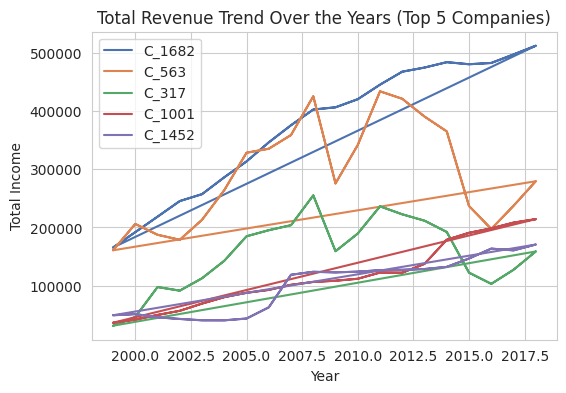

In [ ]:
# Get the top N companies based on Net Income
top_n_companies = analysis_data3.groupby('Name')['TotalRevenue'].sum().nlargest(5).index

# Plotting Net Income trend for the top N companies
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
for company in top_n_companies:
    company_data = analysis_data3[analysis_data3['Name'] == company]
    plt.plot(company_data['Year'], company_data['TotalRevenue'], label=company)

plt.xlabel('Year')
plt.ylabel('Total Income')
plt.title('Total Revenue Trend Over the Years (Top 5 Companies)')
plt.legend()
plt.show()



The graph shows the Net Income Trend over years for top 5 companies.
The trend shows that overall all companies performed well in around years 2010 to 2013.
For year 2017, the desparity in the graph shows that while all other 4 top companies struggled, there was one company which performed exceptionally well. The profitable company may have a unique market positioning, superior cost and operational efficiency, product diversification, or innovative practices, contributing to its financial success compared to competitors experiencing losses.

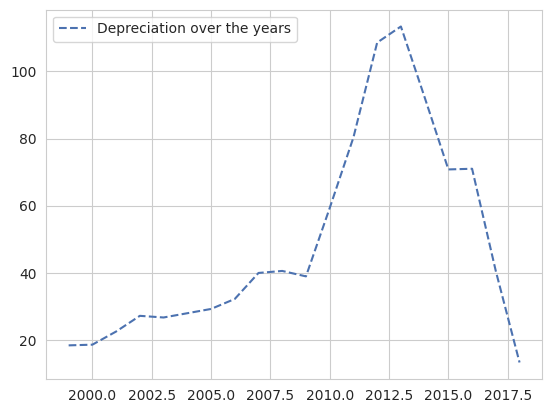

In [ ]:
# Query to analyze the depreciation trend over the years
query_analysis4 = "SELECT Year,Depreciation FROM YearlyFinancialTrend GROUP BY Year"
depreciation_year = pd.read_sql_query(query_analysis4, conn)

plt.plot(depreciation_year['Year'], depreciation_year['Depreciation'], label = "Depreciation over the years", linestyle="--")
plt.legend()
plt.show()

From the above plot, it is clearly visible that between the years 2008 and 2015 the depreciation was quite high which indicates a possibility of bankruptcy.

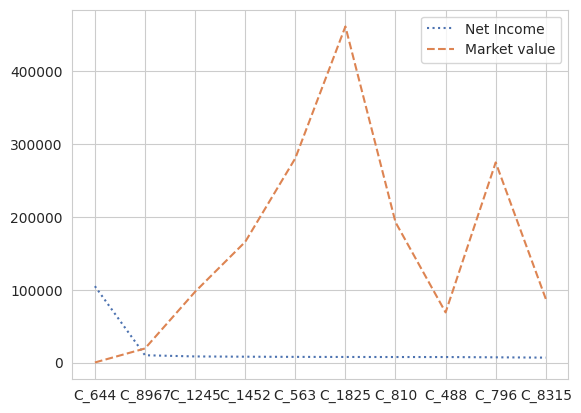

In [ ]:
# This query retrieves the Net Income and Market value to asses if any relationship exists between them
query_analysis5 = "SELECT NetIncome,Marketvalue,Name FROM CompanyWiseTrend GROUP BY Name ORDER BY NetIncome DESC LIMIT 10"
income_market_value = pd.read_sql_query(query_analysis5, conn)

plt.plot(income_market_value['Name'], income_market_value['NetIncome'], label = "Net Income", linestyle=":")
plt.plot(income_market_value['Name'], income_market_value['MarketValue'], label = "Market value", linestyle="--")
plt.legend()
plt.show()

This plot shows the net income and market value variation for 10 companies with the highest net income. The net income plot shows that most of the companies are in the same range. The plot indicates that the market value of a company is not related to its net income. The company with the highest net income has the lowest market value here.

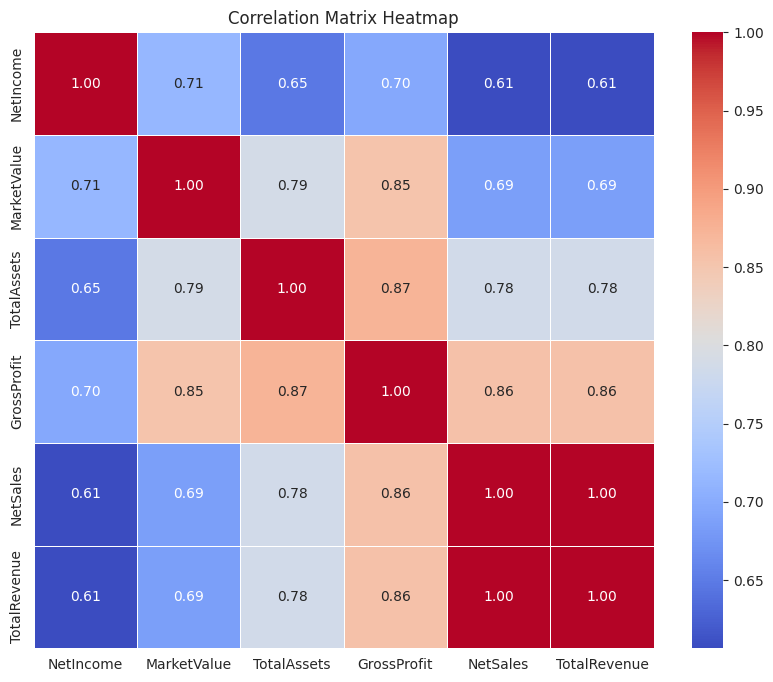

In [ ]:
# Select relevant columns for correlation analysis
correlation_data = analysis_data6[['NetIncome', 'MarketValue', 'TotalAssets', 'GrossProfit', 'NetSales', 'TotalRevenue']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
#The CompanyWiseTrend table is joined with Sales table with Name and Year to find correlation between the parameters
query_analysis6 = """
SELECT CW.Name, CW.Year, CW.NetIncome, CW.MarketValue, CW.TotalAssets, CW.GrossProfit,
       S.NetSales, S.GrossProfit AS SalesGrossProfit, S.TotalRevenue
FROM CompanyWiseTrend CW
LEFT JOIN Sales S ON CW.Name = S.Name AND CW.Year = S.Year;
"""
conn = create_connection(normalized_database_filename)
analysis_data6 = pd.read_sql_query(query_analysis6, conn)

  Name  Year  NetIncome  MarketValue  TotalAssets  GrossProfit  NetSales  \
0  C_1  1999     35.163     372.7519      740.998      191.226  1024.333   
1  C_1  2000     18.531     377.1180      701.854      160.444   874.255   
2  C_1  2001    -58.939     364.5928      710.199      112.244   638.721   
3  C_1  2002    -12.410     143.3295      686.621      109.590   606.337   
4  C_1  2003      3.504     308.9071      709.292      128.656   651.958   

   SalesGrossProfit  TotalRevenue  
0           191.226      1024.333  
1           160.444       874.255  
2           112.244       638.721  
3           109.590       606.337  
4           128.656       651.958  


The heatmap above shows the correlation between parameters. From the plot it is visible that Net Sales and Total Revenue are correlated. So we have to remove one in order reduce redundancy.

# Advanced Data Analysis And Machine Learning




In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import LabelEncoder
conn = create_connection('bankrupcy.db')

cursor = conn.cursor()

query = '''
    SELECT CI.*, CWT.*
    FROM CompanyStatusSummary CI
    LEFT JOIN CompanyWiseTrend CWT ON CI.Name = CWT.Name
'''

df = pd.read_sql_query(query, conn)

In [ ]:
df_train = df[df['Year'] < 2016]
df_test = df[df['Year'] >= 2016]

X_train = df_train.drop(['Status', 'Name'], axis = 1)
y_train = df_train['Status']

X_test = df_test.drop(['Status', 'Name'], axis = 1)
y_test = df_test['Status']

In [ ]:
#changing target labels
df['Status'] = df['Status'].map({'alive':1,'failed':0})

In [ ]:
# k-NN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy: {:.2f}%".format(accuracy_knn*100))

KNN Accuracy: 97.52%


Confusion Matrix:
[[  134   218]
 [  225 17279]]


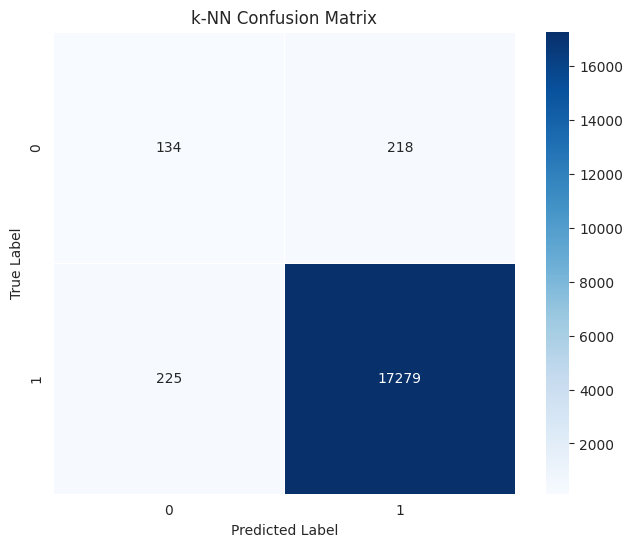

k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.38      0.38       352
           1       0.99      0.99      0.99     17504

    accuracy                           0.98     17856
   macro avg       0.68      0.68      0.68     17856
weighted avg       0.98      0.98      0.98     17856



In [ ]:
# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:")
print(cm_knn)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('k-NN Confusion Matrix')
plt.show()

# Classification Report
cr_knn = classification_report(y_test, y_pred_knn)
print("k-NN Classification Report:")
print(cr_knn)

In [ ]:
import xgboost as xgb
# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Predictions
y_pred = xgb_model.predict(X_test)

# Accuracy
xgb_accuracy = accuracy_score(y_test_encoded, y_pred)

print("XGB Accuracy: {:.2f}%".format(xgb_accuracy*100))

XGB Accuracy: 98.01%


In [ ]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(cm_xgb)

# Classification Report
cr_xgb = classification_report(y_test_encoded, y_pred)
print("Classification Report:")
print(cr_xgb)

Confusion Matrix:
[[   72   280]
 [   76 17428]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.20      0.29       352
           1       0.98      1.00      0.99     17504

    accuracy                           0.98     17856
   macro avg       0.74      0.60      0.64     17856
weighted avg       0.97      0.98      0.98     17856



In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy
print("Random Forest Accuracy: {:.2f}%".format(accuracy*100))

Random Forest Accuracy: 98.13%


[[   59   293]
 [   41 17463]]


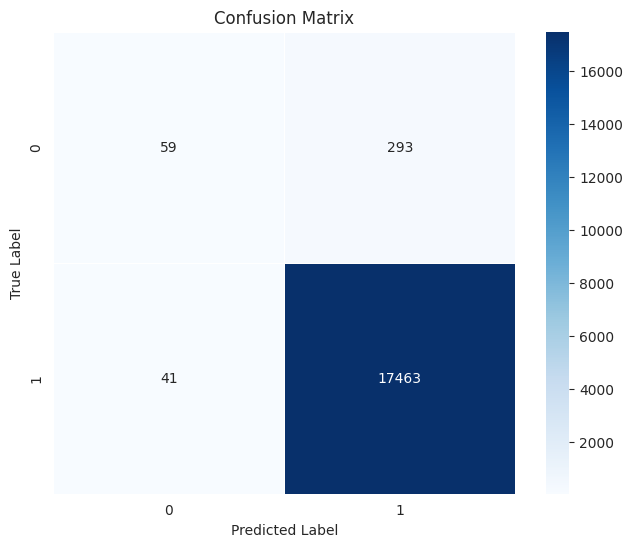

              precision    recall  f1-score   support

           0       0.59      0.17      0.26       352
           1       0.98      1.00      0.99     17504

    accuracy                           0.98     17856
   macro avg       0.79      0.58      0.63     17856
weighted avg       0.98      0.98      0.98     17856



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
cr = classification_report(y_test, y_pred)
print(cr)


*   Interpretation of Result: In the analysis of the U.S. Bankruptcy dataset, both Random Forest and XGBoost ensemble models demonstrated comparable levels of accuracy but KNN is not suitable.
    1. Notably, the precision for predicting 'failed' status was found to be quite high at 0.79 for Random Forest, indicating its effectiveness in correctly identifying companies at risk of bankruptcy. This performance is particularly significant given the imbalanced nature of the dataset, where 94% of the entries are labeled as 'alive'.
    2. It was observed that the K-Nearest Neighbors (KNN) algorithm did not yield as effective results for the 'failed' status as the ensemble methods did. While XGBoost showed a precision of 0.59 for 'failed' status, Random Forest outperformed with a precision of 0.79.
    3. This disparity underscores the strength of ensemble models like Random Forest and XGBoost in handling imbalanced data, particularly in contrast to the KNN algorithm. Ensemble methods, through their construction of multiple decision trees and aggregation of results, are better equipped to distinguish between minority and majority classes, even in datasets with significant class imbalances.
